 Using real world data

 I will  use the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs i will also use Convolutional layers to improve the model's performance.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first step i will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now i need to read the data from the csv file. 



In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Skip the header
        next(reader)
        
        for row in reader:
            # Append time (timestep)
            times.append(len(times))
            # Append temperature as a float
            temperatures.append(float(row[1]))

            
    return times, temperatures

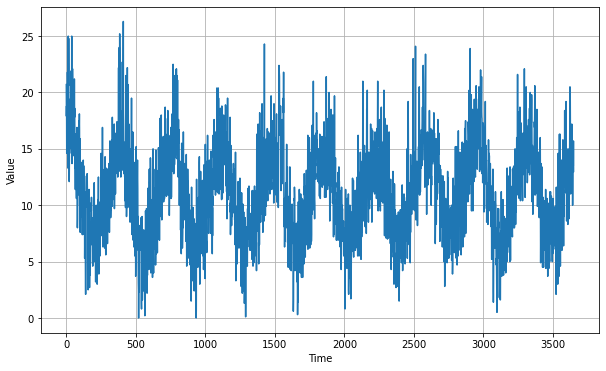

In [5]:
# Test the function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data



In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture



In [8]:
def create_uncompiled_model():

    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((64, 1), input_shape=(64,)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])

    return model

We can test our model with the code below. If we get an error, it's likely that our model is returning a sequence. We can indeed use an LSTM with `return_sequences=True` but we have to feed it into another layer that generates a single prediction. 

In [9]:
# Test the uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()
    
# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("The current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate 

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [10]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    min_loss_lr = 10**(np.argmin(history.history['loss']) / 20 - 4)
    print(f"Minimum Loss Learning Rate: {min_loss_lr}")
    
    return history


In [11]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 12s 120ms/step - loss: 10.3992 - mae: 10.8986 - lr: 1.0000e-06
Epoch 2/100
77/77 [==============================] - 7s 91ms/step - loss: 10.3036 - mae: 10.8029 - lr: 1.1220e-06
Epoch 3/100
77/77 [==============================] - 7s 86ms/step - loss: 10.2497 - mae: 10.7489 - lr: 1.2589e-06
Epoch 4/100
77/77 [==============================] - 6s 81ms/step - loss: 10.2048 - mae: 10.7039 - lr: 1.4125e-06
Epoch 5/100
77/77 [==============================] - 6s 82ms/step - loss: 10.1618 - mae: 10.6609 - lr: 1.5849e-06
Epoch 6/100
77/77 [==============================] - 6s 82ms/step - loss: 10.1184 - mae: 10.6174 - lr: 1.7783e-06
Epoch 7/100
77/77 [==============================] - 6s 82ms/step - loss: 10.0730 - mae: 10.5720 - lr: 1.9953e-06
Epoch 8/100
77/77 [==============================] - 6s 83ms/step - loss: 10.0248 - mae: 10.5236 - lr: 2.2387e-06
Epoch 9/100
77/77 [==============================] - 7s 83ms/step - loss: 9.9728 - mae

(0.0001, 10.0, 0.0, 10.0)

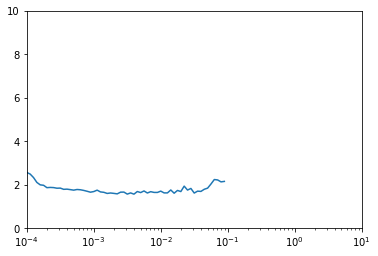

In [12]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model
Now that i have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this : 



In [13]:
def create_model():

    
    model = create_uncompiled_model()


    # Use Adam optimizer with default learning rate
    optimizer = tf.keras.optimizers.Adam(1e-4)

    # Compile the model passing in the appropriate loss
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])


    return model

In [14]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 12s 113ms/step - loss: 87.4384 - mae: 8.3965
Epoch 2/50
77/77 [==============================] - 7s 88ms/step - loss: 35.4404 - mae: 4.8783
Epoch 3/50
77/77 [==============================] - 7s 87ms/step - loss: 20.9163 - mae: 3.6319
Epoch 4/50
77/77 [==============================] - 6s 83ms/step - loss: 17.0459 - mae: 3.2605
Epoch 5/50
77/77 [==============================] - 7s 85ms/step - loss: 14.7296 - mae: 3.0054
Epoch 6/50
77/77 [==============================] - 7s 85ms/step - loss: 11.9543 - mae: 2.6858
Epoch 7/50
77/77 [==============================] - 7s 84ms/step - loss: 10.6872 - mae: 2.5422
Epoch 8/50
77/77 [==============================] - 7s 83ms/step - loss: 10.1970 - mae: 2.4934
Epoch 9/50
77/77 [==============================] - 6s 82ms/step - loss: 9.5784 - mae: 2.4205
Epoch 10/50
77/77 [==============================] - 6s 81ms/step - loss: 9.3085 - mae: 2.3790
Epoch 11/50
77/77 [==============================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [16]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts




In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:




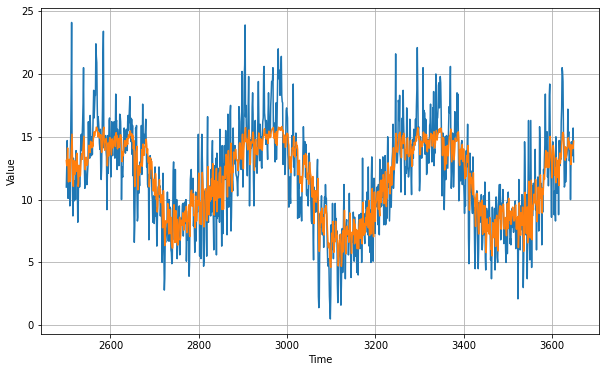

In [18]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.66, mae: 1.85 for forecast


In [20]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/


**Congratulations on finishing this applied course!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**